In [1]:
%matplotlib inline

## Decomposition: [Dictionary Learning]()
- Sparse DL
- Generic DL
- Minibatch DL

## [Sparse Dictionary Learning]()
- SparseCoder transforms signals into sparse linear combinations of values from a fixed, precomputed dictionary.
- Dictionary learning can use various transform methods via ```transform_method```:
    - Orthogonal Matching Pursuit (OMP)
    - Least Angle Regression
    - Lasso Lars
    - Lasso with coordinate descent
    - Thresholding

## Example: sparse coding with precomputed dictionary
- This example compares different sparse coding methods using SparseCoding.
- it transforms a signal as a sparse combination of Ricker wavelets.
- Ricker wavelets, aka "Mexican Hats" or 2nd derivative of Gaussians, are not particularly good kernels for piecewise constant signals like this, so it illustrates how adding different atom widths matters.

In [2]:
from distutils.version import LooseVersion
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import SparseCoder


# Discrete sub-sampled Ricker (Mexican hat) wavelet
def ricker_function(resolution, center, width):
    x = np.linspace(0, resolution - 1, 
                    resolution)
    x = ((2 / (np.sqrt(3 * width) * np.pi ** .25))
         * (1 - (x - center) ** 2 / width ** 2)
         * np.exp(-(x - center) ** 2 / (2 * width ** 2)))
    return x


# Dictionary of Ricker (Mexican hat) wavelets
def ricker_matrix(width, resolution, n_components):
    centers = np.linspace(0, resolution - 1, 
                          n_components)
    D = np.empty((n_components, 
                  resolution))
    for i, center in enumerate(centers):
        D[i] = ricker_function(resolution, 
                               center, 
                               width)
    D /= np.sqrt(np.sum(D ** 2, 
                        axis=1))[:, 
                                 np.newaxis]
    return D

In [3]:
resolution   = 1024
subsampling  = 3  # subsampling factor
width        = 100
n_components = resolution // subsampling

# Compute a wavelet dictionary
D_fixed = ricker_matrix(width        = width, 
                        resolution   = resolution,
                        n_components = n_components)

D_multi = np.r_[tuple(ricker_matrix(width        = w, 
                                    resolution   = resolution,
                                    n_components = n_components // 5)
                for w in (10, 50, 100, 500, 1000))]

In [4]:
# Generate a signal
y                = np.linspace(0, resolution - 1, resolution)
first_quarter    = y < resolution / 4
y[first_quarter] = 3.
y[np.logical_not(first_quarter)] = -1.

# List the different sparse coding methods in the following format:
# (title, transform_algorithm, transform_alpha,
#  transform_n_nozero_coefs, color)

estimators = [('OMP',   'omp',        None, 15,   'navy'),
              ('Lasso', 'lasso_lars', 2,    None, 'turquoise'), ]

lw = 2
# Avoid FutureWarning about default value change when numpy >= 1.14
lstsq_rcond = None if LooseVersion(np.__version__) >= '1.14' else -1

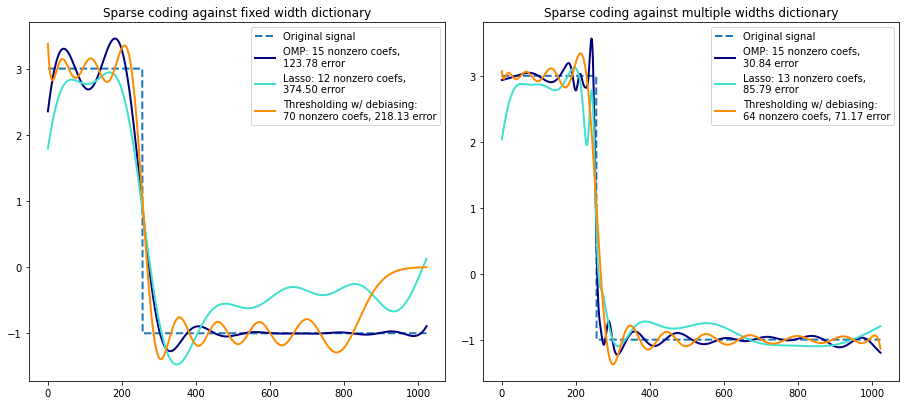

In [5]:
plt.figure(figsize=(13, 6))
for subplot, (D, title) in enumerate(zip((D_fixed, 
                                          D_multi),
                                         ('fixed width', 
                                          'multiple widths'))):

    plt.subplot(1, 2, subplot + 1)
    plt.title('Sparse coding against %s dictionary' % title)
    plt.plot(y, lw=lw, linestyle='--', label='Original signal')

    # Do a wavelet approximation
    for title, algo, alpha, n_nonzero, color in estimators:
        coder = SparseCoder(dictionary                = D, 
                            transform_n_nonzero_coefs = n_nonzero,
                            transform_alpha           = alpha, 
                            transform_algorithm       = algo)

        x             = coder.transform(y.reshape(1, -1))
        density       = len(np.flatnonzero(x))
        x             = np.ravel(np.dot(x, D))
        squared_error = np.sum((y - x) ** 2)
        plt.plot(x, 
                 color=color, lw=lw,
                 label='%s: %s nonzero coefs,\n%.2f error'
                 % (title, density, squared_error))

    # Soft thresholding debiasing
    coder = SparseCoder(dictionary          = D, 
                        transform_algorithm = 'threshold',
                        transform_alpha     = 20)
    
    x      = coder.transform(y.reshape(1, -1))
    _, idx = np.where(x != 0)

    x[0, idx], _, _, _ = np.linalg.lstsq(D[idx, :].T,
                                         y, 
                                         rcond = lstsq_rcond)

    x             = np.ravel(np.dot(x, D))
    squared_error = np.sum((y - x) ** 2)

    plt.plot(x, color='darkorange', lw=lw,
             label='Thresholding w/ debiasing:\n%d nonzero coefs, %.2f error'
             % (len(idx), squared_error))
    plt.axis('tight')
    plt.legend(shadow=False, loc='best')
plt.subplots_adjust(.04, .07, .97, .90, .09, .2)
plt.show()

## [Generic Dictionary learning](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.DictionaryLearning.html#sklearn.decomposition.DictionaryLearning)

In [6]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

try:  # SciPy >= 0.16 have face in misc
    from scipy.misc import face
    face = face(gray=True)
except ImportError:
    face = sp.face(gray=True)

In [7]:
# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
face = face / 255.

# downsample for higher speed
face = face[::4, ::4] + face[1::4, ::4] + face[::4, 1::4] + face[1::4, 1::4]
face /= 4.0
height, width = face.shape

# Distort the right half of the image
print('Distorting image...')
distorted = face.copy()
distorted[:, width // 2:] += 0.075 * np.random.randn(height, width // 2)

# Extract all reference patches from the left half of the image
print('Extracting reference patches...')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print('done in %.2fs.' % (time() - t0))

Distorting image...
Extracting reference patches...
done in 0.02s.


Learning the dictionary...
done in 3.61s.


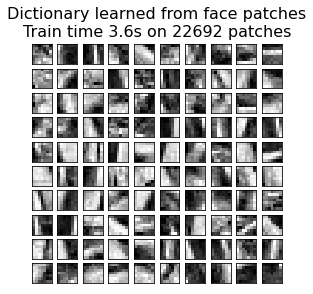

In [8]:
# Learn the dictionary from reference patches

print('Learning the dictionary...')
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1, n_iter=500)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from face patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

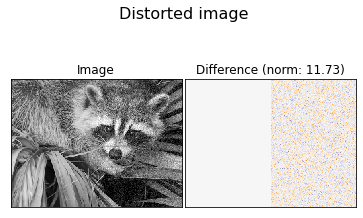

In [9]:
# Display the distorted image

def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference ** 2)))
    plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)

show_with_diff(distorted, face, 'Distorted image')

Extracting noisy patches... 
done in 0.00s.
Orthogonal Matching Pursuit
1 atom...
done in 1.16s.
Orthogonal Matching Pursuit
2 atoms...
done in 2.13s.
Least-angle regression
5 atoms...
done in 21.39s.
Thresholding
 alpha=0.1...
done in 0.19s.


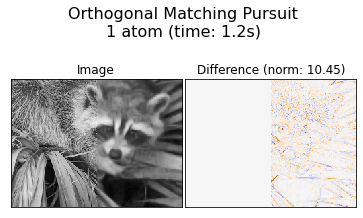

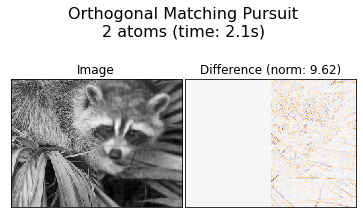

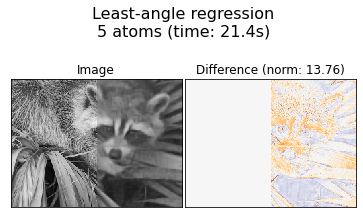

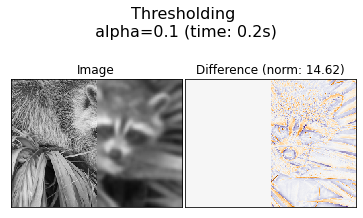

In [10]:
# Extract noisy patches and reconstruct them using the dictionary

print('Extracting noisy patches... ')
t0 = time()
data = extract_patches_2d(distorted[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))

transform_algorithms = [
    ('Orthogonal Matching Pursuit\n1 atom', 'omp',
     {'transform_n_nonzero_coefs': 1}),
    ('Orthogonal Matching Pursuit\n2 atoms', 'omp',
     {'transform_n_nonzero_coefs': 2}),
    ('Least-angle regression\n5 atoms', 'lars',
     {'transform_n_nonzero_coefs': 5}),
    ('Thresholding\n alpha=0.1', 'threshold', {'transform_alpha': .1})]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    reconstructions[title] = face.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2:] = reconstruct_from_patches_2d(
        patches, (height, width // 2))
    dt = time() - t0
    print('done in %.2fs.' % dt)
    show_with_diff(reconstructions[title], face,
                   title + ' (time: %.1fs)' % dt)

plt.show()

## [Minibatch Dictionary learning](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.MiniBatchDictionaryLearning.html#sklearn.decomposition.MiniBatchDictionaryLearning)
- Faster, but less accurate.
- Best suited for large datasets.